## Import the libraries for viz, data wrangling and ML

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tarfile
import tensorflow as tf
import tensorflow_datasets as tfds

from google.cloud import storage


## Ingest the data from Google Cloud Storage

### Initialize a Google storage object

In [2]:
client = storage.Client()

### Download to local folder

In [3]:
bucket_name = "christmas-sweaters"
blob_name = "sweaters-live.tgz"

bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(blob_name)
blob.download_to_filename(blob_name)

print("Downloaded blob {} to {}.".format(blob.name, blob_name))

Downloaded blob sweaters-live.tgz to sweaters-live.tgz.


### Extract TAR to **Keras** dataset folder

In [4]:
data_dir = "/home/jupyter/.keras/datasets/sweaters-live"

file = tarfile.open(blob_name)
file.extractall(data_dir)
file.close()


### Set uniform size of pictures --> 180x180 pixels

In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Use **Keras** utils to create Train and Validate Data Sets

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 925 files belonging to 2 classes.
Using 740 files for training.


2021-12-20 16:03:02.701721: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 925 files belonging to 2 classes.
Using 185 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['cute', 'goofy']


### Preview the images

2021-12-20 16:03:06.084484: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


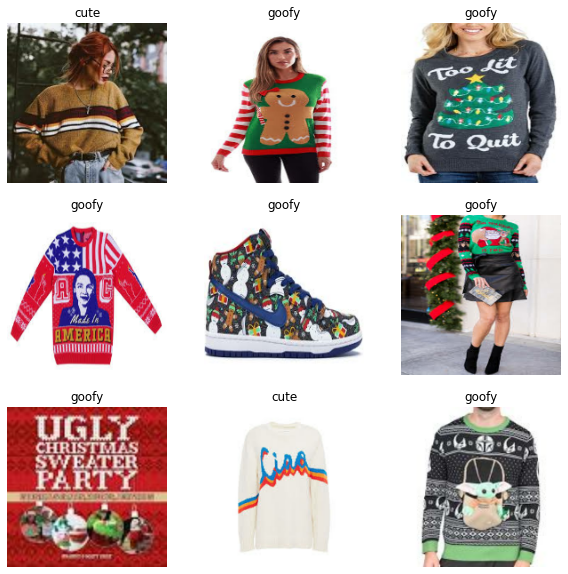

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalize the image vectors

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create and compile model

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### A function to plot loss

In [15]:

def plot_loss(history):
  plt.plot(history.history['loss'],
           label='loss')
  plt.plot(history.history['val_loss'],
           label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Drinks]')
  plt.legend()
  plt.grid(True)

### Fit the model

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
24/24 [==============================] - 13s 519ms/step - loss: 0.6365 - accuracy: 0.6122 - val_loss: 0.5765 - val_accuracy: 0.7568
Epoch 2/3
24/24 [==============================] - 11s 471ms/step - loss: 0.4835 - accuracy: 0.8108 - val_loss: 0.4485 - val_accuracy: 0.8108
Epoch 3/3
24/24 [==============================] - 12s 491ms/step - loss: 0.2973 - accuracy: 0.8865 - val_loss: 0.2981 - val_accuracy: 0.8757


### Plot the loss

In [ ]:
plot_loss(history)